In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install Dependencies

In [ ]:
!pip3 install flair
!pip install contractions
!pip install beautifulsoup4
!pip install twython
!pip install pyspark==3.0.2
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

# Create data sample

In [6]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 

c=0

appended_data = []
max_v=500000
with bz2.open(path_to_file, 'rb') as s_file:
    # with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            c+=1
            instance = json.loads(instance) # loading a sample
            df = pd.json_normalize(instance)
            # df = df.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
            appended_data.append(df)
            # print(instance)
            if c%100000==0:
              print(c)
            if c==max_v:
                break

              # break
            # urls = instance['urls'] # extracting list of links
            # domains = []
            # for url in urls:
            #     tld = get_domain(url)
            #     domains.append(tld)
            # instance['domains'] = domains # updating the sample with domain name
            # d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

appended_data = pd.concat(appended_data)
# quotes = appended_data.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
appended_data.describe()

100000
200000
300000
400000
500000


,numOccurrences
count,500000.000000
mean,3.284298
std,12.457685
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1125.000000


In [ ]:
print(c)

In [44]:
# appended_data.reset_index(drop=True, inplace=True)
# appended_data.drop(["index"], axis=1, inplace=True)
appended_data.head()

,quoteID,quotation
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...
3,2020-02-15-000053,"... [ I ] f it gets to the floor,"
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...


# Imports

In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import flair

import pyspark.pandas as ps
import os
from ast import literal_eval
import bz2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import numpy as np

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
#print(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Preprocessing

In [4]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # print(document)
    # strip HTML
    # document = strip_html_tags(document)
    # document = re.sub(r'[hH][tT][tT][pP][Ss]?:\/\/.*[\r\n]* ?', '', document)
    st=re.search(r'\[([^]]+)\]', document)
    # print(document)
    if(st):
      st=st.group(1)
      document = document.replace(st,"")
      # print(st)
    
    document = ' '.join(word for word in document.split() )#if word.lower() not in STOPWORDS) 
    # document = st+document[]
    document = REPLACE_BY_SPACE_RE.sub(' ', document) 
    # lower case
    document = document.lower()
    # remove links
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    # document = remove_accented_chars(document)
    # expand contractions    
    # document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    #special_char_pattern = re.compile(r'([{.(-)!}])')
    #document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    # document= ' '.join(stemmer.stem(i) for i in document.split())
    document = document.strip()
    if(st):
      sb=st.lower().strip()
      if(len(sb)>1):
        sb+=" "
      document = sb + document
    
    # document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    # print(document)
    return document

# a=pre_process_document(appended_data.iloc[4]['quotation'])

# Saving/Loading sample data

In [4]:
# out='/content/drive/MyDrive/ADA/quotes_sample.csv'
# appended_data.to_csv(out,index=False)
appended_data=pd.read_csv('/content/drive/MyDrive/ADA/quotes_sample.csv')
appended_data.head()

,quoteID,quotation
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...
3,2020-02-15-000053,"... [ I ] f it gets to the floor,"
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...


In [61]:
dataset=appended_data.copy()
# pre_process_corpus = np.vectorize(pre_process_document)
dataset['quotation'] = dataset['quotation'].apply(pre_process_document)
dataset.head()

,quoteID,quotation
0,2020-01-28-000082,despite the efforts of the partners to create ...
1,2020-01-16-000088,department of homeland security was livid and ...
2,2020-02-10-000142,he madhav also disclosed that the illegal brib...
3,2020-02-15-000053,if it gets to the floor
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...


In [71]:
# out='/content/drive/MyDrive/ADA/quotes_sample_preprocessed2.csv'
# dataset.to_csv(out,index=False)

# Loading Dataset

In [2]:
dataset=pd.read_csv('/content/drive/MyDrive/ADA/quotes_sample_preprocessed2.csv')
dataset.head()

,quoteID,quotation
0,2020-01-28-000082,despite the efforts of the partners to create ...
1,2020-01-16-000088,department of homeland security was livid and ...
2,2020-02-10-000142,he madhav also disclosed that the illegal brib...
3,2020-02-15-000053,if it gets to the floor
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...


In [6]:
dataset.dropna(axis=0, inplace=True)

In [62]:
sample=dataset.sample(n=100,random_state=0)
sample.reset_index(inplace=True,drop=True)
print(sample.head())

             quoteID                                          quotation
0  2020-03-11-052346              so he decided he just had to tell you
1  2020-01-01-016038  if you do what we tell you to do you will go t...
2  2020-04-03-081020            with great power comes great narcissism
3  2020-01-13-097344  yusaku maezawas serious matchmaking documentar...
4  2020-02-05-019027  even when lee doesnt score she handles the bal...


In [9]:
# from flair.data import
# flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
nltk_sentiment = SentimentIntensityAnalyzer()

2021-11-11 08:03:35,512 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpqn39d5hr


100%|██████████| 265512723/265512723 [00:09<00:00, 28413101.98B/s]

2021-11-11 08:03:45,193 copying /tmp/tmpqn39d5hr to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-11-11 08:03:45,725 removing temp file /tmp/tmpqn39d5hr
2021-11-11 08:03:45,885 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
sent=dataset.iloc[12]['quotation']
print(sent)
print()
print(nltk_sentiment.polarity_scores(sent))

s = flair.data.Sentence(sent)
flair_sentiment.predict(s)
total_sentiment = s.labels
print(total_sentiment)

we deserve a president like him

{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}
[POSITIVE (0.8976)]


In [8]:
# print(type(nltk_sentiment.polarity_scores(q)))
nltk_sentiment = SentimentIntensityAnalyzer()

def classify_sentiment(doc):
  #  print(doc)
   scores = nltk_sentiment.polarity_scores(doc)
   neg_sc=scores['neg']	
   neu_sc=scores['neu']
   pos_sc=scores['pos']
   compound_sc=scores['compound']
   sentiment=np.argmax(np.array([neg_sc,neu_sc,pos_sc,compound_sc]))
   scores['sentiment'] = sentiment
   return scores
  
# classify_sentiment(sent,0)

applied_df = dataset.apply(lambda row: classify_sentiment(row.quotation), axis='columns', result_type='expand')
applied_df.head()

,neg,neu,pos,compound,sentiment
0,0.000,0.768,0.232,0.8720,3.0
1,0.184,0.579,0.237,0.0000,1.0
2,0.116,0.837,0.047,-0.4939,1.0
3,0.000,1.000,0.000,0.0000,1.0
4,0.000,0.870,0.130,0.3041,1.0


In [9]:
np.unique(applied_df['sentiment'], return_counts=True)

(array([0., 1., 2., 3.]), array([  4495, 417374,   1947,  76177]))

In [10]:
print(dataset.shape,applied_df.shape)
df = pd.concat([dataset, applied_df],axis='columns')
df.head()

(499993, 2) (499993, 5)


,quoteID,quotation,neg,neu,pos,compound,sentiment
0,2020-01-28-000082,despite the efforts of the partners to create ...,0.000,0.768,0.232,0.8720,3.0
1,2020-01-16-000088,department of homeland security was livid and ...,0.184,0.579,0.237,0.0000,1.0
2,2020-02-10-000142,he madhav also disclosed that the illegal brib...,0.116,0.837,0.047,-0.4939,1.0
3,2020-02-15-000053,if it gets to the floor,0.000,1.000,0.000,0.0000,1.0
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...,0.000,0.870,0.130,0.3041,1.0


In [11]:
out='/content/drive/MyDrive/ADA/quotes_sentiments.csv'
df.to_csv(out,index=False)

In [77]:
rev_label=['negative','neutral','positive','compound']
temp = df[['quotation','sentiment']]
temp.head()
print(temp.shape)

(499993, 2)


In [ ]:
rev_label=['negative','neutral','positive','compound']
temp['sentiment'] = temp['sentiment'].map(lambda row: rev_label[int(row)])

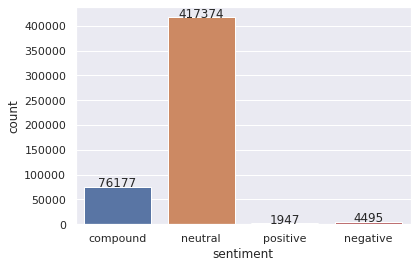

In [81]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=temp)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Neutral Words


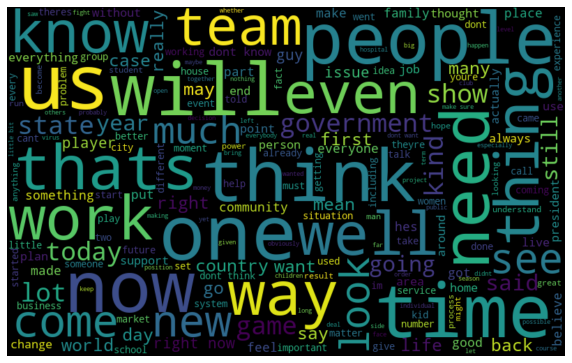

Negative Words


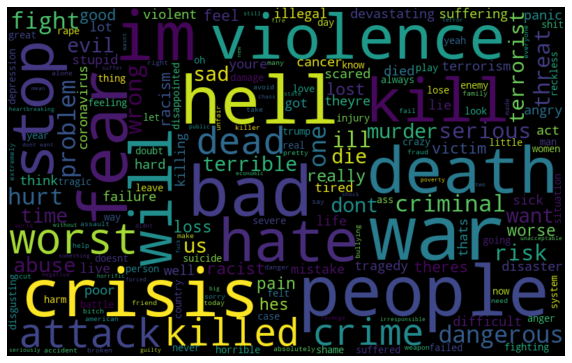

Positive Words


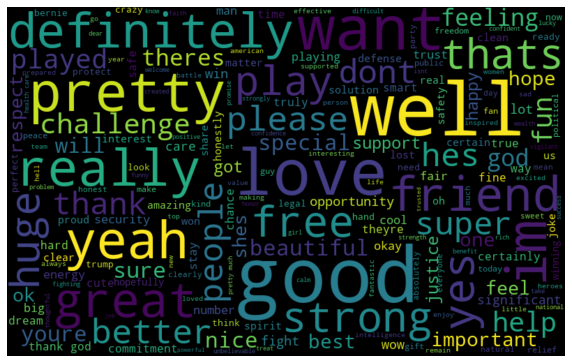

Compound Words


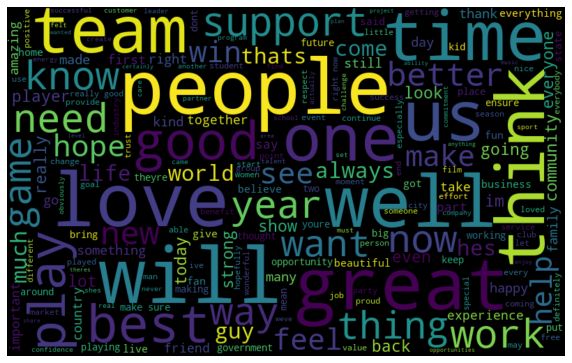

In [80]:

print("Neutral Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Words")

pos_words =' '.join([text for text in df['quotation'][df['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Compound Words")

compound_words =' '.join([text for text in df['quotation'][df['sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(compound_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [3]:
sentiment_data=pd.read_csv('/content/drive/MyDrive/ADA/quotes_sentiments.csv')

In [8]:
sentiment_data

,quoteID,quotation,neg,neu,pos,compound,sentiment
0,2020-01-28-000082,despite the efforts of the partners to create ...,0.000,0.768,0.232,0.8720,3.0
1,2020-01-16-000088,department of homeland security was livid and ...,0.184,0.579,0.237,0.0000,1.0
2,2020-02-10-000142,he madhav also disclosed that the illegal brib...,0.116,0.837,0.047,-0.4939,1.0
3,2020-02-15-000053,if it gets to the floor,0.000,1.000,0.000,0.0000,1.0
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...,0.000,0.870,0.130,0.3041,1.0
...,...,...,...,...,...,...,...
499988,2020-04-15-004470,anyone who violates the quarantine will be hel...,0.236,0.764,0.000,-0.7579,1.0
499989,2020-02-21-005024,apples anticompetitive behavior,0.000,1.000,0.000,0.0000,1.0
499990,2020-01-30-007507,approximately 30 more precipitation can be exp...,0.000,1.000,0.000,0.0000,1.0
499991,2020-01-30-007577,are looking at 2016 through a microscope and n...,0.193,0.807,0.000,-0.5849,1.0


In [7]:
appended_data.to_csv('/content/drive/MyDrive/ADA/quotes_500k.csv',index=False)

In [8]:
temp = pd.merge(sentiment_data, appended_data, on='quoteID', how='left')
t1 = temp.drop(['quotation_y','probas','urls','phase','neg', 'neu',	'pos', 'compound'], axis = 1)
t2 = t1.rename({'quotation_x': 'quotation'}, axis=1)
t2.head()

,quoteID,quotation,sentiment,speaker,qids,date,numOccurrences
0,2020-01-28-000082,despite the efforts of the partners to create ...,3.0,None,[],2020-01-28 08:04:05,1
1,2020-01-16-000088,department of homeland security was livid and ...,1.0,Sue Myrick,[Q367796],2020-01-16 12:00:13,1
2,2020-02-10-000142,he madhav also disclosed that the illegal brib...,1.0,None,[],2020-02-10 23:45:54,1
3,2020-02-15-000053,if it gets to the floor,1.0,None,[],2020-02-15 14:12:51,2
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...,1.0,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4


In [10]:
rev_label=['negative','neutral','positive','compound']
t2['sentiment'] = t2['sentiment'].map(lambda row: rev_label[int(row)])
t2.head()

,quoteID,quotation,sentiment,speaker,qids,date,numOccurrences
0,2020-01-28-000082,despite the efforts of the partners to create ...,compound,None,[],2020-01-28 08:04:05,1
1,2020-01-16-000088,department of homeland security was livid and ...,neutral,Sue Myrick,[Q367796],2020-01-16 12:00:13,1
2,2020-02-10-000142,he madhav also disclosed that the illegal brib...,neutral,None,[],2020-02-10 23:45:54,1
3,2020-02-15-000053,if it gets to the floor,neutral,None,[],2020-02-15 14:12:51,2
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...,neutral,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4


In [12]:
# print(t2.shape)
t2=t2[t2['qids'].map(lambda d: len(d)) > 0]
# print(t2.shape)
t3 = t2.drop(['qids'], axis = 1)
t3.head()

(327972, 7)
(327972, 7)


,quoteID,quotation,sentiment,speaker,date,numOccurrences
1,2020-01-16-000088,department of homeland security was livid and ...,neutral,Sue Myrick,2020-01-16 12:00:13,1
4,2020-01-24-000168,i met them when they just turned 4 and 7 they ...,neutral,Meghan King Edmonds,2020-01-24 20:37:09,4
7,2020-01-17-000357,the delay will have an impact on slough but th...,neutral,Dexter Smith,2020-01-17 13:03:00,1
8,2020-04-02-000239,the scheme treats addiction as an illness and ...,neutral,Barry Coppinger,2020-04-02 14:18:20,1
9,2020-03-19-000276,these actions will allow households who have a...,compound,Ben Carson,2020-03-19 19:14:00,1


In [14]:
t3.to_csv('/content/drive/MyDrive/ADA/sample_with_sentiment_and_speaker.csv',index=False)

# Extra

In [ ]:
ts.memory_usage(deep=True)
ts2 = ts.copy()
ts2["name"] = ts2["name"].astype("category")
ts2.memory_usage(deep=True)
ts2["id"] = pd.to_numeric(ts2["id"], downcast="unsigned")

ts2[["x", "y"]] = ts2[["x", "y"]].apply(pd.to_numeric, downcast="float")

In [ ]:
https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html
use dask?pyspark?

In [ ]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
# # path_to_out = '/content/quotes-2020-domains.json.bz2'
c=0

big_data = []
# max_v=500000
with bz2.open(path_to_file, 'rb') as s_file:
    # with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            c+=1
            instance = json.loads(instance) # loading a sample
            df = pd.json_normalize(instance)
            df = df.drop(['probas','urls','phase'], axis=1)
            big_data.append(df)
            # print(instance)
            if c%100000==0:
              print(c)
            # if c==max_v:
              # break

              # break
            # urls = instance['urls'] # extracting list of links
            # domains = []
            # for url in urls:
            #     tld = get_domain(url)
            #     domains.append(tld)
            # instance['domains'] = domains # updating the sample with domain name
            # d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

big_data = pd.concat(big_data)
# quotes = appended_data.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
big_data.describe()

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000


In [ ]:
# out='/content/drive/MyDrive/ADA/quotes_2020.csv'
# big_data.to_csv(out,index=False)

In [ ]:
quotes_all = ps.read_json("/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2")

In [3]:
quotes_all.shape

(5244449, 9)

In [8]:
quotes_all.columns # remove phase probas urls

Index(['date', 'numOccurrences', 'phase', 'probas', 'qids', 'quotation',
       'quoteID', 'speaker', 'urls'],
      dtype='object')

In [38]:
quotes_all.head()

,date,numOccurrences,phase,probas,qids,quotation,quoteID,speaker,urls
0,2020-01-28 08:04:05,1,E,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[],[ D ] espite the efforts of the partners to cr...,2020-01-28-000082,None,[http://israelnationalnews.com/News/News.aspx/...
1,2020-01-16 12:00:13,1,E,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[Q367796],[ Department of Homeland Security ] was livid ...,2020-01-16-000088,Sue Myrick,[http://thehill.com/opinion/international/4782...
2,2020-02-10 23:45:54,1,E,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[],... He (Madhav) also disclosed that the illega...,2020-02-10-000142,None,[https://indianexpress.com/article/business/ec...
3,2020-02-15 14:12:51,2,E,"[[None, 0.581], [Andy Harris, 0.4191]]",[],"... [ I ] f it gets to the floor,",2020-02-15-000053,None,[https://patriotpost.us/opinion/68622-trump-bu...
4,2020-01-24 20:37:09,4,E,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[Q20684375],[ I met them ] when they just turned 4 and 7. ...,2020-01-24-000168,Meghan King Edmonds,[https://people.com/parents/meghan-king-edmond...


In [3]:
speaker_attribs = pd.read_parquet('/content/drive/MyDrive/ADA/speaker_attributes.parquet')

In [26]:
speaker_attribs.shape

(9055981, 15)

In [28]:
speaker_attribs.columns

Index(['aliases', 'date_of_birth', 'nationality', 'gender', 'lastrevid',
       'ethnic_group', 'US_congress_bio_ID', 'occupation', 'party',
       'academic_degree', 'id', 'label', 'candidacy', 'type', 'religion'],
      dtype='object')

In [26]:
speaker_attribs_d = speaker_attribs.drop(['aliases', 'date_of_birth', 'lastrevid', 'type', 'ethnic_group', 'US_congress_bio_ID', 'party',
       'academic_degree','candidacy', 'religion'], axis=1)

In [27]:
speaker_attribs_d.notnull().sum()/len(speaker_attribs_d)

nationality    0.410320
gender         0.784631
occupation     0.703743
id             1.000000
label          0.943430
dtype: float64

In [17]:
df_speakers = speaker_attribs_d.sample(100000)
df_speakers.head()

,nationality,gender,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,religion
0,"[Q161885, Q30]",[Q6581097],None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",[Q682443]
1,[Q145],[Q6581097],[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,None
2,[Q31],[Q6581097],None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,None
3,[Q30],[Q6581097],None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]","[Q329646, Q682443, Q33203]"
4,[Q29],[Q6581097],None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,None


In [28]:
speaker_attribs_d.shape

(9055981, 5)

In [29]:
import pandas as pd
persons = pd.read_csv("https://storage.googleapis.com/pantheon-public-data/person_2020_update.csv.bz2", low_memory=False)
# hpi is the index of famous-ness
persons.head()

,id,wd_id,wp_id,slug,name,occupation,prob_ratio,gender,twitter,alive,l,hpi_raw,bplace_name,bplace_lat,bplace_lon,bplace_geonameid,bplace_country,birthdate,birthyear,dplace_name,dplace_lat,dplace_lon,dplace_geonameid,dplace_country,deathdate,deathyear,bplace_geacron_name,dplace_geacron_name,is_group,l_,age,non_en_page_views,coefficient_of_variation,hpi
0,18934,Q9458,18934,Muhammad,Muhammad,RELIGIOUS FIGURE,0.0,M,NaN,False,193,36,Mecca,21.416667,39.816667,21021.0,Saudi Arabia,NaN,570.0,Medina,24.466667,39.600000,36636.0,Saudi Arabia,0632-06-08,632.0,Mecca,NaN,False,27.918400,1450.0,5160422.0,3.199355,100.000000
1,17414699,Q720,17414699,Genghis_Khan,Genghis Khan,MILITARY PERSONNEL,0.0,M,NaN,False,154,35,Khentii Mountains,48.783300,109.167000,7300427.0,Mongolia,NaN,1162.0,Yinchuan,38.472000,106.258900,465955.0,China,1227-08-18,1227.0,NaN,NaN,False,25.843621,858.0,3249211.0,2.753641,97.723669
2,18079,Q762,18079,Leonardo_da_Vinci,Leonardo da Vinci,INVENTOR,0.0,M,NaN,False,221,35,Republic of Florence,43.783333,11.250000,11525.0,Italy,1452-04-15,1452.0,Clos Lucé,47.410230,0.991525,98219.0,France,1519-05-02,1519.0,NaN,NaN,False,17.545406,568.0,5362406.0,4.796629,97.460691
3,14627,Q935,14627,Isaac_Newton,Isaac Newton,PHYSICIST,0.0,M,NaN,False,215,35,Woolsthorpe Manor,52.809167,-0.630556,140503.0,United Kingdom,1643-01-04,1643.0,Kensington,51.500000,-0.190000,54732.0,United Kingdom,1727-03-31,1726.0,NaN,NaN,False,21.608920,378.0,3431331.0,4.632474,96.836567
4,17914,Q255,17914,Ludwig_van_Beethoven,Ludwig van Beethoven,COMPOSER,0.0,M,NaN,False,194,35,Bonn,50.733333,7.100000,3295.0,Germany,1770-12-16,1770.0,Vienna,48.200000,16.366667,55866.0,Austria,1827-03-26,1827.0,NaN,Austria,False,19.796430,250.0,5179518.0,3.926626,96.583969


In [30]:
num_persons = len(persons.index)
print("In total, we have {} number of persons in the dataset".format(num_persons))

In total, we have 88937 number of persons in the dataset


In [31]:
print("The dataset contains the following columns: \n\n{}".format(list(persons.columns)))

The dataset contains the following columns: 

['id', 'wd_id', 'wp_id', 'slug', 'name', 'occupation', 'prob_ratio', 'gender', 'twitter', 'alive', 'l', 'hpi_raw', 'bplace_name', 'bplace_lat', 'bplace_lon', 'bplace_geonameid', 'bplace_country', 'birthdate', 'birthyear', 'dplace_name', 'dplace_lat', 'dplace_lon', 'dplace_geonameid', 'dplace_country', 'deathdate', 'deathyear', 'bplace_geacron_name', 'dplace_geacron_name', 'is_group', 'l_', 'age', 'non_en_page_views', 'coefficient_of_variation', 'hpi']


In [32]:
persons['occupation'].value_counts()

SOCCER PLAYER    16923
POLITICIAN       15640
ACTOR            10017
WRITER            5777
SINGER            3544
                 ...  
CHEF                 7
CRITIC               5
GAMER                4
GO PLAYER            2
BULLFIGHTER          1
Name: occupation, Length: 101, dtype: int64

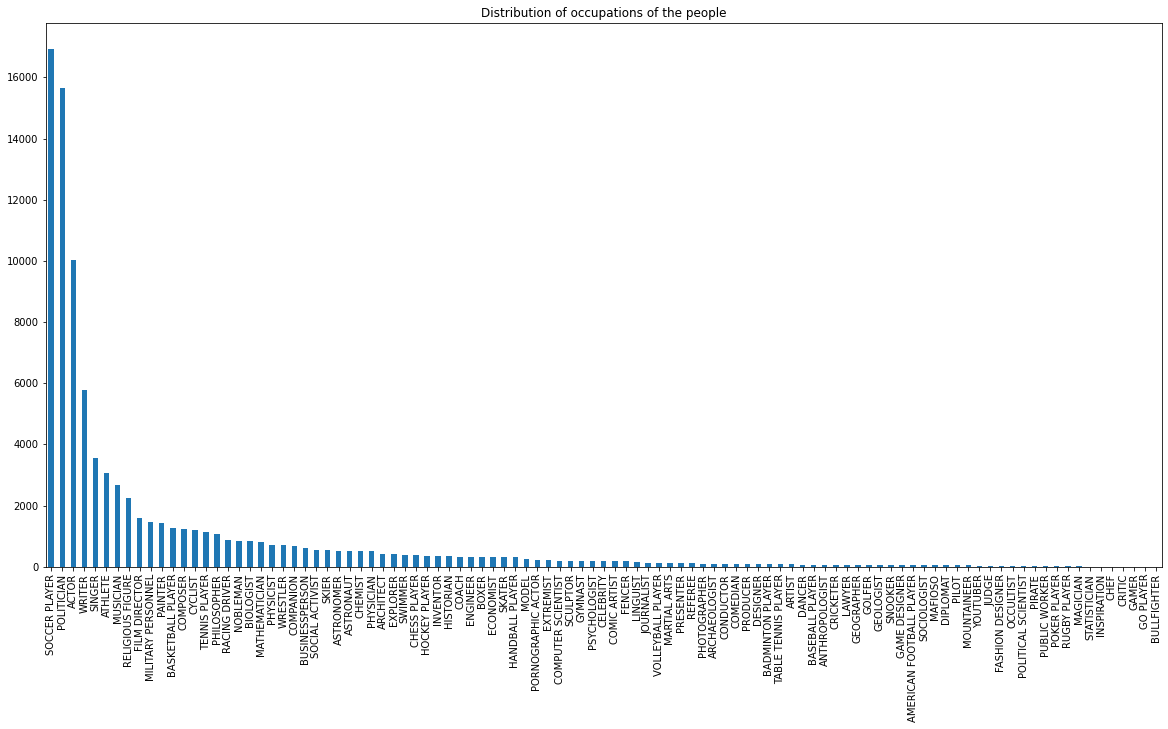

In [33]:
persons['occupation'].value_counts().plot(kind='bar', figsize=(20,10), title="Distribution of occupations of the people")

In [38]:
# # Run below commands
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://apache.osuosl.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
# !tar xf spark-3.2.0-bin-hadoop3.2.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
# os.environ["PYARROW_IGNORE_TIMEZONE"] = '1'

In [ ]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
quotes_df=pd.read_json(path_to_file, chunksize=100, lines=True)

In [ ]:
# qt=quotes_all['speaker']
# temp = literal_eval(qt)
# print(len(temp))
# print(temp[:5])